In [2]:
import numpy as np
import pandas as pd
import quantecon as qe
from ast import literal_eval
from sklearn.ensemble import RandomForestRegressor
import ternary
import random
import plotly.figure_factory as ff
import colorsys
from matplotlib import pyplot as plt

In [18]:
def creating_samples(samples_number, element):
    gen=0
    uniform_number = len(element)
    uniform_samples = (-qe.simplex_grid(len(element), 1)+1)/(len(element)-1)
    if samples_number > uniform_number:
        random_samples = np.random.rand((samples_number-uniform_number), len(element))
        for i in range(samples_number-uniform_number):
            random_samples[i] = np.around(random_samples[i]/sum(random_samples[i]), decimals = 3)
        sample = np.vstack((uniform_samples, random_samples))
    else:
        sample = uniform_samples[:samples_number]
    samples = []
    for i in range(samples_number):
        samples.append(list(sample[i]))
    samples = np.array(samples)
    samples = np.around(samples, decimals = 3)
    generation = []
    for i in range (samples_number):
            generation.append(gen)

    ID = np.arange(1, (samples_number+1))

    data = {'ID' : ID, 'Elements': [element], 'Generation': generation}
    df = pd.DataFrame(data=data, index = np.arange(samples_number))
    df = pd.concat([df, pd.DataFrame(([[i] for i in samples]), columns = ['Position'])], axis = 1)
    df.to_csv("Result/Initial Population.txt", sep='\t', index=False, mode='w')
    return df

In [4]:
#Loading data and fitting
df_old = pd.read_csv('Data/AuIrOsPdPtReRhRu_0.60_compositions_and_targets.csv')
X_columns_old = ['Pt','Pd','Au','Ru','Rh','Ir','Re','Os']
x_old = df_old[X_columns_old].to_numpy()
y_old = df_old['current_over_capacitance'].to_numpy()

#Rndom Forest Regression
reg = RandomForestRegressor(n_estimators = 1024,
                           bootstrap = True,
                           max_depth = None,
                           max_features = 'auto',
                           min_samples_leaf = 1,
                           min_samples_split = 2,
                           oob_score = True)
reg = reg.fit(x_old, y_old)

In [9]:
len(qe.simplex_grid(8, 20)/20)

888030

In [13]:
#Determine the best position
grid = qe.simplex_grid(8, 20)/20
zeros = np.zeros(len(grid)).reshape(-1,1)

grid = pd.DataFrame(grid,columns=[X_columns_old])
x = grid[X_columns_old].to_numpy()
y = reg.predict(grid.to_numpy())
grid['Activity'] = y

In [14]:
best_grid = grid.iloc[np.argmin(grid['Activity'])][0:8].to_numpy()

In [15]:
print(best_grid, grid.iloc[np.argmin(grid['Activity'])]['Activity'])

[0.35 0.3  0.3  0.05 0.   0.   0.   0.  ] -1.0677367675781226


In [16]:
#Making Class
class pso:
    def __init__ (self, data, magnitude_limit=0.20, target = np.array([0.333, 0.333, 0.333])):
        self.datalog = data
        #Reading "Elements" columns from string to list
        self.datalog['Elements'] = self.datalog["Elements"].apply(lambda x: literal_eval(x))
        
        #Select latest generation
        self.generation = self.datalog['Generation'].max()
        
        #Creating np.array of "Position" column and dropping the string type "Position" column
        self.position = []
        for i in range(self.datalog['ID'].max()):
            self.position.append(list(np.fromstring(self.datalog['Position'][i][1:-1], dtype=float, sep=' ')))
        self.position = np.array(self.position)
        self.datalog = self.datalog.drop(columns=['Position'])
        self.datalog = pd.concat([self.datalog, pd.DataFrame(([[i] for i in self.position]), columns = ['Position'])], axis = 1)
        
        #Creating "Region" column
        self.determine_initial_region()
        self.datalog = self.datalog.assign(Region = self.region)
        
        #Creating "Velocity" column for the "0" generation
        if self.generation == 0:
            self.velocity = np.around((-(self.position - target)), decimals = 3)
            #Turning velocity into unit vector with certain magnitude
            self.velocity = self.unit_vector_velocity(magnitude_limit)
            self.datalog = pd.concat([self.datalog, pd.DataFrame(([[i] for i in self.velocity]), columns = ['Velocity'])], axis = 1)

        #Create "Visited" column
        self.visited = []
        for i in range(self.datalog['ID'].max()):
            check = self.datalog.at[i, 'Region'] == self.datalog.loc[0:(i-1)]['Region']
            if np.count_nonzero(check) == 0:
                self.visited.append(False)
            else:
                self.visited.append(True)
        self.datalog['Visited'] = self.visited
        
        
        #Creating blank "Activity" column
        self.datalog = pd.concat([self.datalog, pd.DataFrame(columns = ['Activity'], index = np.arange(self.datalog['ID'].max()))], axis = 1)      

        #Filling the "Activity" column with RFR
        self.f_activity(self.datalog)
            
        #Creating dataframe of the latest generation
        self.working_generation = self.datalog.loc[self.datalog['Generation']==self.generation]
    
    def create_new_velocity(self, factor_1, factor_2, factor_3, mutation_rate, mutation_prob, magnitude_limit):
        #Creating new velocity
        for i in range(len(self.working_generation)):
            new_velocity = -(factor_1 * self.working_generation.at[i, 'Velocity'] + 
                        factor_2 * self.delta_gen_best((i+1), 'Activity') * self.delta_gen_best((i+1), 'Position') + 
                        factor_3 * self.delta_individual_best((i+1), 'Activity') * self.delta_individual_best((i+1), 'Position'))       
           #Mutation process
            self.working_generation.at[i,'Velocity'] = self.mutate(new_velocity, mutation_rate, mutation_prob, magnitude_limit)
            
        #Normalization
        self.normalize_velocity()
        #Limitting velocity
        self.limitting_velocity(magnitude_limit)
        return
    
    
    def change_position(self):
        #Changing position
        for i in range(len(self.working_generation)):    
            new_position = self.working_generation['Position'][i] + self.working_generation['Velocity'][i]
            if new_position.max() > 1 or new_position.min() < 0:
                new_position = self.working_generation['Position'][i] - self.working_generation['Velocity'][i]*2
            self.working_generation.at[i,'Position'] = np.around(new_position, decimals = 3)
        return
        
    """def bounce(self, new_position):
        correction = []
        if new_position[0] > 1 or new_position[0] < 0:
        c = np.array([-1.3, 0.4, 0.9])
    def correct_velocity(self, velocity)

        d = np.abs(c)
        e = d - (sum(d)/3)
        f = e/np.sqrt(sum(e**2))
        g = f * np.sqrt(sum(d**2))"""


    def correct_position(self, new_position):
        while new_position.max() > 1 or new_position.min() < 0:
            correction = []
            for i in range(len(self.working_generation['Elements'][0])):
                if new_position[i] > 1:
                    #Fill the previous column of correction by half of the correction
                    for x in range(i):
                        correction.append(-(1 - new_position[i])/(len(self.working_generation['Elements'][0])-1))
                    #Fill column of correction
                    correction.append(1 - new_position[i])
                    #Fill the next column of correction by half of the correction
                    for x in range(len(self.working_generation['Elements'][0])-1-i):
                        correction.append(-(1 - new_position[i])/(len(self.working_generation['Elements'][0])-1))

                if new_position[i] < 0:
                    #Fill the previous column of correction by half of the correction
                    for x in range(i):
                        correction.append(-(0 - new_position[i])/(len(self.working_generation['Elements'][0])-1))
                    #Fill column of correction
                    correction.append(0 - a[i])
                    #Fill the next column of correction by half of the correction
                    for x in range(len(self.working_generation['Elements'][0])-1-i):
                        correction.append(-(0 - new_position[i])/(len(self.working_generation['Elements'][0])-1))

            correction = np.array(correction)
            correction = np.reshape(correction, (int(len(correction)/len(self.working_generation['Elements'][0])), len(self.working_generation['Elements'][0])))

            #Add the correction to the old position 
            for i in range(len(correction)):
                 new_position = new_position + correction[i]
        return new_position
    
    
    
    def move(self, factor_1, factor_2, factor_3, mutation_rate, mutation_prob, magnitude_limit):
        #Updating generation
        self.generation += 1
        self.working_generation['Generation'] += 1
        
        #Updating velocity
        self.create_new_velocity(factor_1, factor_2, factor_3, mutation_rate, mutation_prob, magnitude_limit)     
        
        #Updating position
        self.change_position()
        
        #Updating region
        self.new_region()
        
        #Checking region
        self.check_region()
        
        #Filling the "Activity" column with RFR
        self.f_activity(self.working_generation)
        
        #Concating the tables
        self.datalog = pd.concat([self.datalog, self.working_generation])
        self.datalog = self.datalog.reset_index(drop=True)
        self.store_datalog()
        return 

    
    
    def f_activity(self, dataframe):
        global reg
        a = [0, 0, 0, 0, 0]
        for i in range(len(dataframe)):
            dataframe.at[i, 'Activity'] = float(reg.predict(np.reshape((np.hstack((dataframe.at[i, 'Position'], a))), (1, -1))))
        return 

   
    def unit_vector_velocity(self, magnitude_limit):
        self.unit_vector_velocity = []
        for i in range(self.datalog['ID'].max()):
            self.unit_vector_velocity.append(list(self.velocity[i]/np.sqrt(sum(self.velocity[i]**2))))
        self.unit_vector_velocity = np.array(self.unit_vector_velocity) * magnitude_limit
        self.unit_vector_velocity = np.around(self.unit_vector_velocity, decimals = 3)
        return self.unit_vector_velocity
    
    def normalize_velocity(self):
        for i in range(len(self.working_generation)):
            self.working_generation.at[i, 'Velocity'] = self.working_generation.at[i, 'Velocity'] - (sum(self.working_generation.at[i, 'Velocity'])/len(self.working_generation['Elements'][0]))
            self.working_generation.at[i, 'Velocity'] = np.around(self.working_generation.at[i, 'Velocity'], decimals= 3)
        return

    def limitting_velocity(self, magnitude_limit):
        for i in range(len(self.working_generation)):
            if np.sqrt(sum(self.working_generation.at[i, 'Velocity']**2)) > magnitude_limit:
                self.working_generation.at[i, 'Velocity'] = self.working_generation.at[i, 'Velocity'] / np.sqrt(sum(self.working_generation.at[i, 'Velocity']**2)) * magnitude_limit
                self.working_generation.at[i, 'Velocity'] = np.around(self.working_generation.at[i, 'Velocity'], decimals= 3)
        return
    
    def mutate(self, new_velocity, mutation_rate, mutation_prob, magnitude_limit):
        mutated_velocity = []
        for i in range(len(new_velocity)):
            mutation = np.random.rand()
            step_size_i = 0
            if mutation < mutation_prob:
                step_size_i = np.random.uniform((0-mutation_rate), (0+mutation_rate))
            mutated_velocity.append(new_velocity[i] + magnitude_limit * step_size_i)
        mutated_velocity = np.array(mutated_velocity)
        return mutated_velocity
    
   
    def g_best(self):
        return self.datalog.loc[np.argmin(self.datalog['Activity'])]
    
    def gen_best(self):
        return self.working_generation.loc[np.argmin(self.working_generation['Activity'])]
           
    def individual_best(self, ID):
        self.i_data = self.datalog[self.datalog['ID']==ID].reset_index(drop=True)
        return self.i_data.loc[np.argmin(self.i_data['Activity'])]
    
    def delta_gen_best(self, ID, parameter):
        return self.working_generation[self.working_generation['ID']==ID][parameter].reset_index(drop=True)[0] - self.gen_best()[parameter]
    
    def delta_individual_best(self, ID, parameter):
        return self.working_generation[self.working_generation['ID']==ID][parameter].reset_index(drop=True)[0] - self.individual_best(ID)[parameter]      
    
    
    def individual_log(self, ID):
        return self.datalog[self.datalog['ID']==ID].reset_index(drop=True)
    
    def store_datalog(self):
        self.datalog.to_csv("Result/Initial Population_gen "+str(self.generation)+".txt", sep='\t', index=False, mode='w')
        return
    
    def determine_initial_region(self, grid_len = 10):
        simplex_grid = qe.simplex_grid(len(self.datalog['Elements'][0]), grid_len)/grid_len

        #Translating Process
        translate_vector = 1/(grid_len*3)
        grid_points_1 = simplex_grid + np.array([translate_vector, -2*translate_vector, translate_vector])
        grid_points_2 = simplex_grid + np.array([2*translate_vector, -4*translate_vector, 2*translate_vector])
        self.grid_points = np.vstack((grid_points_1, grid_points_2))
        self.grid_points = np.around(self.grid_points, decimals = 3)
        self.grid_points = self.grid_points[self.grid_points[:, 0].argsort()]

        #Deleting grid points outside the space
        self.grid_points = np.delete(self.grid_points, np.where(self.grid_points<0)[0], axis = 0)
        self.grid_points = np.delete(self.grid_points, np.where(self.grid_points>1)[0], axis = 0)

        #Determining region
        self.region = []
        for i in range(len(self.datalog)):
            distance = []
            for x in range(len(self.grid_points)):
                distance.append(np.sqrt(sum((self.datalog.at[i, 'Position']-self.grid_points[x])**2)))
            distance = np.array(distance)
            self.region.append(distance.argmin())
        self.region = np.array(self.region)
        return
    
            
    def new_region(self):
        for i in range(len(self.working_generation)):    
            distance = []
            for x in range(len(self.grid_points)):
                distance.append(np.sqrt(sum((self.working_generation.at[i, 'Position']-self.grid_points[x])**2)))
            distance = np.array(distance)
            self.working_generation.at[i, 'Region'] = distance.argmin()
        return
    
    def check_region(self):
        for i in range(len(self.working_generation)):
            check = self.working_generation.at[i, 'Region'] == self.datalog.loc[0:(self.generation+1)*6-1]['Region']
            if np.count_nonzero(check) == 0:
                self.working_generation.at[i, 'Visited'] = False
            else:
                self.working_generation.at[i, 'Visited'] = True
        return
    
    def count_occurences(self):
        #Count Occurrences of Each Grid
        self.grid_count = []
        for i in range(len(self.grid_points)):
            self.grid_count.append((self.datalog['Region'] == i).sum())
        self.grid_count = np.array(self.grid_count)
        return
    
    
    def exploitation_value(self):
        self.exploitation_data = []
        for i in range(self.generation+1):
            max_observation = self.datalog[0:(i+1)*self.datalog['ID'].max()]
            self.exploitation_data.append(1-(len(np.unique(max_observation['Region'])))/len(max_observation))
        self.exploitation_data = np.array(self.exploitation_data)
        self.exploitation_data = np.around(self.exploitation_data, decimals = 3)
        return self.exploitation_data[-1]
    
    
    def exploration(self):
        return np.around((len(np.unique(self.region))/len(self.grid_points)), decimals = 4)
    
    
    def exploitation_bar_chart(self, min_number = 3):
        self.count_occurences()
        #Creating Exploration Table
        self.exploration_table = pd.DataFrame(([[i] for i in self.grid_points]), columns = ['Grid'])
        self.exploration_table = self.exploration_table.assign(Region = np.arange(len(self.grid_points)))
        self.exploration_table = self.exploration_table.assign(Count = self.grid_count)

        #Creating table for bar chart
        self.exploitation_bar_chart_table = self.exploration_table.loc[self.exploration_table['Count'] >= min_number].reset_index(drop=True)
        self.exploitation_bar_chart_table['Region'] = self.exploitation_bar_chart_table['Region'].astype(str)
        self.exploitation_bar_chart_table['Grid'] = self.exploitation_bar_chart_table['Grid'].astype(str)

        #Figure Size
        fig = plt.figure(figsize = (10, 7))

        #Horizontal Bar Plot
        plt.bar(self.exploitation_bar_chart_table['Region'], self.exploitation_bar_chart_table['Count'],
                color ='blue',
                width = 0.5)

        plt.xlabel("Region")
        plt.ylabel("Count")
        plt.yticks(np.arange(0, self.generation, step=2))
        plt.title("Exploitation Bar Chart")
        plt.show()
        return
    
    
    def exploitation_vs_generation(self):
        self.exploitation_value()
        y = self.exploitation_data
        x = np.arange(self.generation+1)

        fig = plt.figure(figsize = (7, 5))

        plt.plot(x, y, marker = 'o', color = 'blue')
        plt.xticks(np.arange(0, self.generation+1, 1))
        plt.ylim(0, 1)
        plt.xlabel("Generation")
        plt.ylabel("Exploitation")
        plt.show()
        return
    
    def exploration_scatter(self):
        def hls_to_rgb(x):
            return colorsys.hls_to_rgb(x[0], x[1], x[2])
        points = []
        IDs = []
        colors = []
        start_color = np.array([[1.2, 0.8, 1], [0.29, 0.8, 0.5], [0, 0.8, 1], [1.8, 0.8, 1], [3.6, 0.8, 1], [2.4, 0.8, 1]])
        change = np.array([0, (0.8 - 0.5)/self.generation, 0]) 
        for i in range(len(self.working_generation)):
            IDs.append('ID = '+str(i+1))
            for x in range(self.generation+1):
                points.append(tuple(self.individual_log(i+1)['Position'][x]))
                colors.append(list(start_color[i]-change*x))

        #Parameter for plotting
        scale = 1
        figure, tax = ternary.figure(scale=scale)
        figure.set_size_inches(10, 10)

        #Plotting the starting points
        for i in range(len(self.working_generation)):
            tax.scatter([points[(self.generation+1)*(i+1)-1]], marker='*', color=hls_to_rgb(colors[(self.generation+1)*(i+1)-1]), label=IDs[i])
            #Plotting the movement
            for x in range(self.generation):
                tax.scatter([points[(self.generation+1)*i+(x)]], marker='*', color=hls_to_rgb(colors[(self.generation+1)*i+(x)]))
        tax.scatter([tuple(self.g_best()['Position'])], marker='o', color='black', label='Best Position')
        tax.scatter([tuple(best_grid)], marker='*', color='black', label='Global Minimum')
        tax.legend()


        tax.right_corner_label("Pt", fontsize=16)
        tax.top_corner_label("Pd", fontsize=16)
        tax.left_corner_label("Au", fontsize=16)
        tax.boundary(linewidth=1.0)
        tax.gridlines(multiple=0.1, color="blue")
        tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f")
        tax.clear_matplotlib_ticks()
        tax.get_axes().axis('off')
        tax.show() 
        return 

In [19]:
samples_number = 6
element = ['Pt','Pd','Au','Ru','Rh','Ir','Re','Os']
creating_samples(samples_number, element)

,ID,Elements,Generation,Position
0,1,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.1..."
1,2,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.0..."
2,3,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.143, 0.143, 0.143, 0.0, 0.143..."
3,4,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.143, 0.143, 0.0, 0.143, 0.143..."
4,5,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.143, 0.0, 0.143, 0.143, 0.143..."
5,6,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.0, 0.143, 0.143, 0.143, 0.143..."


In [21]:
magnitude_limit = 0.2
target = np.array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])
population = pso(pd.read_csv('Result/Initial Population.txt', sep='\t'), magnitude_limit, target)

ValueError: operands could not be broadcast together with shapes (19448,8) (3,) 

In [23]:
population.datalog

,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",0,"[0.5, 0.5, 0.0]",73,"[-0.082, -0.082, 0.163]",False,-0.941858
1,2,"[Pt, Pd, Au]",0,"[0.5, 0.0, 0.5]",70,"[-0.082, 0.163, -0.082]",False,-0.926702
2,3,"[Pt, Pd, Au]",0,"[0.0, 0.5, 0.5]",15,"[0.163, -0.082, -0.082]",False,-0.281916
3,4,"[Pt, Pd, Au]",0,"[0.144, 0.17, 0.686]",33,"[0.087, 0.075, -0.163]",False,-0.822627
4,5,"[Pt, Pd, Au]",0,"[0.799, 0.111, 0.09]",94,"[-0.163, 0.078, 0.085]",False,-0.929214
5,6,"[Pt, Pd, Au]",0,"[0.216, 0.437, 0.347]",40,"[0.149, -0.132, -0.018]",False,-0.950432


In [24]:
factor_1 = 0.8
factor_2 = 0.6
factor_3 = 0.7
mutation_prob = 0.7
mutation_rate = 0.3

for i in range(20):
    population.move(factor_1, factor_2, factor_3, mutation_rate, mutation_prob, magnitude_limit)
    display(population.working_generation)
    print(population.g_best()['Position'], population.g_best()['Activity'])
    print(np.sqrt(sum((population.g_best()['Position']-best_grid)**2)))

,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",1,"[0.394, 0.35, 0.256]",61,"[0.053, 0.075, -0.128]",False,-1.023452
1,2,"[Pt, Pd, Au]",1,"[0.354, 0.292, 0.352]",60,"[0.073, -0.146, 0.074]",False,-1.016217
2,3,"[Pt, Pd, Au]",1,"[0.122, 0.372, 0.504]",26,"[-0.061, 0.064, -0.002]",False,-0.763661
3,4,"[Pt, Pd, Au]",1,"[0.102, 0.13, 0.769]",25,"[-0.042, -0.04, 0.083]",False,-0.73836
4,5,"[Pt, Pd, Au]",1,"[0.903, 0.062, 0.035]",99,"[0.104, -0.049, -0.055]",False,-0.893519
5,6,"[Pt, Pd, Au]",1,"[0.119, 0.55, 0.331]",24,"[-0.097, 0.113, -0.016]",False,-0.755348


[0.394 0.35  0.256] -1.0234520507812483
0.06125357132445419


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",2,"[0.369, 0.263, 0.368]",60,"[-0.025, -0.087, 0.112]",True,-1.002305
1,2,"[Pt, Pd, Au]",2,"[0.258, 0.428, 0.312]",40,"[-0.096, 0.136, -0.04]",True,-0.975743
2,3,"[Pt, Pd, Au]",2,"[0.209, 0.305, 0.484]",41,"[0.087, -0.067, -0.02]",False,-0.967166
3,4,"[Pt, Pd, Au]",2,"[0.16, 0.212, 0.629]",27,"[0.058, 0.082, -0.14]",False,-0.846336
4,5,"[Pt, Pd, Au]",2,"[0.777, 0.126, 0.097]",94,"[-0.126, 0.064, 0.062]",True,-0.97236
5,6,"[Pt, Pd, Au]",2,"[0.258, 0.406, 0.336]",40,"[0.139, -0.144, 0.005]",True,-0.961984


[0.394 0.35  0.256] -1.0234520507812483
0.06125357132445419


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",3,"[0.392, 0.336, 0.272]",61,"[0.023, 0.073, -0.096]",True,-1.024461
1,2,"[Pt, Pd, Au]",3,"[0.326, 0.327, 0.345]",53,"[0.068, -0.101, 0.033]",False,-0.987511
2,3,"[Pt, Pd, Au]",3,"[0.157, 0.365, 0.476]",34,"[-0.052, 0.06, -0.008]",False,-0.887723
3,4,"[Pt, Pd, Au]",3,"[0.119, 0.177, 0.705]",25,"[-0.041, -0.035, 0.076]",True,-0.733414
4,5,"[Pt, Pd, Au]",3,"[0.903, 0.051, 0.046]",99,"[0.126, -0.075, -0.051]",True,-0.891
5,6,"[Pt, Pd, Au]",3,"[0.158, 0.473, 0.369]",35,"[-0.1, 0.067, 0.033]",False,-0.892227


[0.392 0.336 0.272] -1.0244610058593733
0.05885575587824865


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",4,"[0.374, 0.226, 0.401]",54,"[-0.018, -0.11, 0.129]",False,-0.999016
1,2,"[Pt, Pd, Au]",4,"[0.31, 0.389, 0.299]",61,"[-0.016, 0.062, -0.046]",True,-0.993328
2,3,"[Pt, Pd, Au]",4,"[0.174, 0.328, 0.496]",34,"[0.017, -0.037, 0.02]",True,-0.963023
3,4,"[Pt, Pd, Au]",4,"[0.208, 0.205, 0.587]",42,"[0.089, 0.028, -0.118]",False,-0.866307
4,5,"[Pt, Pd, Au]",4,"[0.751, 0.145, 0.104]",93,"[-0.152, 0.094, 0.058]",False,-0.959384
5,6,"[Pt, Pd, Au]",4,"[0.272, 0.424, 0.304]",40,"[0.114, -0.049, -0.065]",True,-0.975354


[0.392 0.336 0.272] -1.0244610058593733
0.05885575587824865


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",5,"[0.388, 0.317, 0.296]",61,"[0.014, 0.091, -0.105]",True,-1.032754
1,2,"[Pt, Pd, Au]",5,"[0.35, 0.352, 0.297]",61,"[0.04, -0.037, -0.002]",True,-1.026895
2,3,"[Pt, Pd, Au]",5,"[0.174, 0.365, 0.459]",34,"[-0.0, 0.037, -0.037]",True,-0.956238
3,4,"[Pt, Pd, Au]",5,"[0.144, 0.224, 0.631]",27,"[-0.064, 0.019, 0.044]",True,-0.841316
4,5,"[Pt, Pd, Au]",5,"[0.86, 0.099, 0.041]",98,"[0.109, -0.046, -0.063]",False,-0.902198
5,6,"[Pt, Pd, Au]",5,"[0.18, 0.458, 0.362]",35,"[-0.092, 0.034, 0.058]",True,-0.958384


[0.388 0.317 0.296] -1.032754023437499
0.06977822009767802


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",6,"[0.386, 0.224, 0.391]",60,"[-0.002, -0.093, 0.095]",True,-0.999404
1,2,"[Pt, Pd, Au]",6,"[0.327, 0.39, 0.282]",61,"[-0.023, 0.038, -0.015]",True,-0.996571
2,3,"[Pt, Pd, Au]",6,"[0.177, 0.347, 0.474]",34,"[0.003, -0.018, 0.015]",True,-0.965151
3,4,"[Pt, Pd, Au]",6,"[0.218, 0.23, 0.55]",42,"[0.074, 0.006, -0.081]",True,-0.882798
4,5,"[Pt, Pd, Au]",6,"[0.743, 0.18, 0.078]",94,"[-0.117, 0.081, 0.037]",True,-0.957703
5,6,"[Pt, Pd, Au]",6,"[0.253, 0.43, 0.318]",40,"[0.073, -0.028, -0.044]",True,-0.971811


[0.388 0.317 0.296] -1.032754023437499
0.06977822009767802


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",7,"[0.397, 0.268, 0.336]",60,"[0.011, 0.044, -0.055]",True,-1.005753
1,2,"[Pt, Pd, Au]",7,"[0.315, 0.374, 0.31]",53,"[-0.012, -0.016, 0.028]",True,-0.994573
2,3,"[Pt, Pd, Au]",7,"[0.186, 0.344, 0.468]",34,"[0.009, -0.003, -0.006]",True,-0.966675
3,4,"[Pt, Pd, Au]",7,"[0.198, 0.195, 0.605]",33,"[-0.02, -0.035, 0.055]",True,-0.877215
4,5,"[Pt, Pd, Au]",7,"[0.813, 0.145, 0.043]",97,"[0.07, -0.035, -0.035]",False,-0.94914
5,6,"[Pt, Pd, Au]",7,"[0.221, 0.438, 0.342]",40,"[-0.032, 0.008, 0.024]",True,-0.951227


[0.388 0.317 0.296] -1.032754023437499
0.06977822009767802


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",8,"[0.428, 0.239, 0.334]",69,"[0.031, -0.029, -0.002]",False,-1.008563
1,2,"[Pt, Pd, Au]",8,"[0.348, 0.375, 0.277]",61,"[0.033, 0.001, -0.033]",True,-1.022609
2,3,"[Pt, Pd, Au]",8,"[0.17, 0.31, 0.518]",26,"[-0.016, -0.034, 0.05]",True,-0.9315
3,4,"[Pt, Pd, Au]",8,"[0.241, 0.211, 0.546]",42,"[0.043, 0.016, -0.059]",True,-0.87681
4,5,"[Pt, Pd, Au]",8,"[0.727, 0.198, 0.076]",94,"[-0.086, 0.053, 0.033]",True,-0.958477
5,6,"[Pt, Pd, Au]",8,"[0.226, 0.46, 0.316]",40,"[0.005, 0.022, -0.026]",True,-0.965435


[0.388 0.317 0.296] -1.032754023437499
0.06977822009767802


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",9,"[0.402, 0.265, 0.334]",69,"[-0.026, 0.026, 0.0]",True,-1.006354
1,2,"[Pt, Pd, Au]",9,"[0.307, 0.358, 0.335]",53,"[-0.041, -0.017, 0.058]",True,-0.981551
2,3,"[Pt, Pd, Au]",9,"[0.182, 0.364, 0.452]",34,"[0.012, 0.054, -0.066]",True,-0.961571
3,4,"[Pt, Pd, Au]",9,"[0.194, 0.223, 0.58]",32,"[-0.047, 0.012, 0.034]",False,-0.8922
4,5,"[Pt, Pd, Au]",9,"[0.769, 0.194, 0.038]",94,"[0.042, -0.004, -0.038]",True,-0.955739
5,6,"[Pt, Pd, Au]",9,"[0.227, 0.425, 0.35]",40,"[0.001, -0.035, 0.034]",True,-0.951036


[0.388 0.317 0.296] -1.032754023437499
0.06977822009767802


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",10,"[0.403, 0.285, 0.313]",69,"[0.001, 0.02, -0.021]",True,-1.02227
1,2,"[Pt, Pd, Au]",10,"[0.386, 0.37, 0.244]",61,"[0.079, 0.012, -0.091]",True,-1.014062
2,3,"[Pt, Pd, Au]",10,"[0.146, 0.334, 0.518]",26,"[-0.036, -0.03, 0.066]",True,-0.87012
3,4,"[Pt, Pd, Au]",10,"[0.206, 0.208, 0.583]",42,"[0.012, -0.015, 0.003]",True,-0.867672
4,5,"[Pt, Pd, Au]",10,"[0.724, 0.199, 0.078]",94,"[-0.045, 0.005, 0.04]",True,-0.958992
5,6,"[Pt, Pd, Au]",10,"[0.218, 0.416, 0.368]",40,"[-0.009, -0.009, 0.018]",True,-0.951189


[0.388 0.317 0.296] -1.032754023437499
0.06977822009767802


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",11,"[0.396, 0.281, 0.324]",60,"[-0.007, -0.004, 0.011]",True,-1.016283
1,2,"[Pt, Pd, Au]",11,"[0.304, 0.369, 0.327]",53,"[-0.082, -0.001, 0.083]",True,-0.977067
2,3,"[Pt, Pd, Au]",11,"[0.216, 0.365, 0.418]",41,"[0.07, 0.031, -0.1]",True,-0.951737
3,4,"[Pt, Pd, Au]",11,"[0.179, 0.244, 0.574]",32,"[-0.027, 0.036, -0.009]",True,-0.942655
4,5,"[Pt, Pd, Au]",11,"[0.761, 0.181, 0.059]",94,"[0.037, -0.018, -0.019]",True,-0.957188
5,6,"[Pt, Pd, Au]",11,"[0.245, 0.396, 0.361]",46,"[0.027, -0.02, -0.007]",False,-0.951921


[0.388 0.317 0.296] -1.032754023437499
0.06977822009767802


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",12,"[0.424, 0.273, 0.304]",69,"[0.028, -0.008, -0.02]",True,-1.017699
1,2,"[Pt, Pd, Au]",12,"[0.388, 0.357, 0.255]",61,"[0.084, -0.012, -0.072]",True,-1.023452
2,3,"[Pt, Pd, Au]",12,"[0.147, 0.319, 0.533]",26,"[-0.069, -0.046, 0.115]",True,-0.878276
3,4,"[Pt, Pd, Au]",12,"[0.226, 0.232, 0.539]",42,"[0.047, -0.012, -0.035]",True,-0.882422
4,5,"[Pt, Pd, Au]",12,"[0.73, 0.18, 0.091]",94,"[-0.031, -0.001, 0.032]",True,-0.964889
5,6,"[Pt, Pd, Au]",12,"[0.221, 0.372, 0.408]",41,"[-0.024, -0.024, 0.047]",True,-0.951333


[0.388 0.317 0.296] -1.032754023437499
0.06977822009767802


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",13,"[0.444, 0.232, 0.325]",69,"[0.02, -0.041, 0.021]",True,-1.011476
1,2,"[Pt, Pd, Au]",13,"[0.345, 0.341, 0.314]",53,"[-0.043, -0.016, 0.059]",True,-1.015757
2,3,"[Pt, Pd, Au]",13,"[0.239, 0.352, 0.408]",41,"[0.092, 0.033, -0.125]",True,-0.957375
3,4,"[Pt, Pd, Au]",13,"[0.15, 0.287, 0.56]",32,"[-0.076, 0.055, 0.021]",True,-0.879856
4,5,"[Pt, Pd, Au]",13,"[0.742, 0.189, 0.07]",94,"[0.012, 0.009, -0.021]",True,-0.958239
5,6,"[Pt, Pd, Au]",13,"[0.217, 0.454, 0.329]",40,"[-0.004, 0.082, -0.079]",True,-0.953883


[0.388 0.317 0.296] -1.032754023437499
0.06977822009767802


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",14,"[0.433, 0.214, 0.354]",69,"[-0.011, -0.018, 0.029]",True,-0.995683
1,2,"[Pt, Pd, Au]",14,"[0.412, 0.35, 0.238]",64,"[0.067, 0.009, -0.076]",False,-1.012508
2,3,"[Pt, Pd, Au]",14,"[0.178, 0.318, 0.503]",26,"[-0.061, -0.034, 0.095]",True,-0.9763
3,4,"[Pt, Pd, Au]",14,"[0.235, 0.21, 0.552]",42,"[0.085, -0.077, -0.008]",True,-0.872903
4,5,"[Pt, Pd, Au]",14,"[0.736, 0.193, 0.072]",94,"[-0.006, 0.004, 0.002]",True,-0.959209
5,6,"[Pt, Pd, Au]",14,"[0.245, 0.39, 0.365]",46,"[0.028, -0.064, 0.036]",True,-0.951472


[0.388 0.317 0.296] -1.032754023437499
0.06977822009767802


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",15,"[0.432, 0.251, 0.318]",69,"[-0.001, 0.037, -0.036]",True,-1.022348
1,2,"[Pt, Pd, Au]",15,"[0.366, 0.331, 0.304]",53,"[-0.046, -0.019, 0.066]",True,-1.023537
2,3,"[Pt, Pd, Au]",15,"[0.255, 0.325, 0.42]",41,"[0.077, 0.007, -0.083]",True,-0.963899
3,4,"[Pt, Pd, Au]",15,"[0.203, 0.261, 0.533]",42,"[-0.032, 0.051, -0.019]",True,-0.938069
4,5,"[Pt, Pd, Au]",15,"[0.74, 0.183, 0.078]",94,"[0.004, -0.01, 0.006]",True,-0.958172
5,6,"[Pt, Pd, Au]",15,"[0.249, 0.412, 0.34]",40,"[0.004, 0.022, -0.025]",True,-0.954997


[0.388 0.317 0.296] -1.032754023437499
0.06977822009767802


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",16,"[0.438, 0.195, 0.368]",74,"[0.006, -0.056, 0.05]",False,-0.989446
1,2,"[Pt, Pd, Au]",16,"[0.356, 0.343, 0.303]",53,"[-0.01, 0.012, -0.001]",True,-1.023445
2,3,"[Pt, Pd, Au]",16,"[0.215, 0.346, 0.439]",41,"[-0.04, 0.021, 0.019]",True,-0.956495
3,4,"[Pt, Pd, Au]",16,"[0.187, 0.274, 0.536]",32,"[-0.016, 0.013, 0.003]",True,-0.946313
4,5,"[Pt, Pd, Au]",16,"[0.707, 0.171, 0.122]",93,"[-0.033, -0.012, 0.044]",True,-0.965058
5,6,"[Pt, Pd, Au]",16,"[0.263, 0.369, 0.369]",46,"[0.014, -0.043, 0.029]",True,-0.960326


[0.388 0.317 0.296] -1.032754023437499
0.06977822009767802


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",17,"[0.441, 0.197, 0.363]",74,"[0.003, 0.002, -0.005]",True,-0.987311
1,2,"[Pt, Pd, Au]",17,"[0.396, 0.339, 0.266]",61,"[0.04, -0.004, -0.037]",True,-1.024078
2,3,"[Pt, Pd, Au]",17,"[0.261, 0.352, 0.387]",46,"[0.046, 0.006, -0.052]",True,-0.965912
3,4,"[Pt, Pd, Au]",17,"[0.218, 0.277, 0.502]",42,"[0.031, 0.003, -0.034]",True,-0.938649
4,5,"[Pt, Pd, Au]",17,"[0.734, 0.199, 0.067]",94,"[0.027, 0.028, -0.055]",True,-0.958701
5,6,"[Pt, Pd, Au]",17,"[0.228, 0.397, 0.375]",46,"[-0.035, 0.028, 0.006]",True,-0.95134


[0.388 0.317 0.296] -1.032754023437499
0.06977822009767802


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",18,"[0.466, 0.183, 0.352]",74,"[0.025, -0.014, -0.011]",True,-0.986513
1,2,"[Pt, Pd, Au]",18,"[0.364, 0.342, 0.295]",61,"[-0.032, 0.003, 0.029]",True,-1.023445
2,3,"[Pt, Pd, Au]",18,"[0.182, 0.362, 0.456]",34,"[-0.079, 0.01, 0.069]",True,-0.961571
3,4,"[Pt, Pd, Au]",18,"[0.187, 0.308, 0.502]",26,"[-0.031, 0.031, 0.0]",True,-0.977824
4,5,"[Pt, Pd, Au]",18,"[0.657, 0.229, 0.114]",84,"[-0.077, 0.03, 0.047]",False,-0.973316
5,6,"[Pt, Pd, Au]",18,"[0.256, 0.402, 0.342]",40,"[0.028, 0.005, -0.033]",True,-0.961157


[0.388 0.317 0.296] -1.032754023437499
0.06977822009767802


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",19,"[0.447, 0.239, 0.314]",69,"[-0.019, 0.056, -0.038]",True,-1.021484
1,2,"[Pt, Pd, Au]",19,"[0.376, 0.349, 0.277]",61,"[0.012, 0.007, -0.018]",True,-1.02339
2,3,"[Pt, Pd, Au]",19,"[0.228, 0.376, 0.396]",46,"[0.046, 0.014, -0.06]",True,-0.950723
3,4,"[Pt, Pd, Au]",19,"[0.194, 0.272, 0.531]",32,"[0.007, -0.036, 0.029]",True,-0.945157
4,5,"[Pt, Pd, Au]",19,"[0.679, 0.233, 0.087]",90,"[0.022, 0.004, -0.027]",False,-0.972322
5,6,"[Pt, Pd, Au]",19,"[0.267, 0.349, 0.385]",46,"[0.011, -0.053, 0.043]",True,-0.966188


[0.388 0.317 0.296] -1.032754023437499
0.06977822009767802


,ID,Elements,Generation,Position,Region,Velocity,Visited,Activity
0,1,"[Pt, Pd, Au]",20,"[0.457, 0.193, 0.35]",74,"[0.01, -0.046, 0.036]",True,-0.988711
1,2,"[Pt, Pd, Au]",20,"[0.339, 0.372, 0.291]",61,"[-0.037, 0.023, 0.014]",True,-1.008734
2,3,"[Pt, Pd, Au]",20,"[0.191, 0.333, 0.475]",34,"[-0.037, -0.043, 0.079]",True,-0.967795
3,4,"[Pt, Pd, Au]",20,"[0.176, 0.333, 0.488]",34,"[-0.018, 0.061, -0.043]",True,-0.967179
4,5,"[Pt, Pd, Au]",20,"[0.683, 0.217, 0.099]",90,"[0.004, -0.016, 0.012]",True,-0.97265
5,6,"[Pt, Pd, Au]",20,"[0.262, 0.392, 0.347]",46,"[-0.005, 0.043, -0.038]",True,-0.960559


[0.388 0.317 0.296] -1.032754023437499
0.06977822009767802


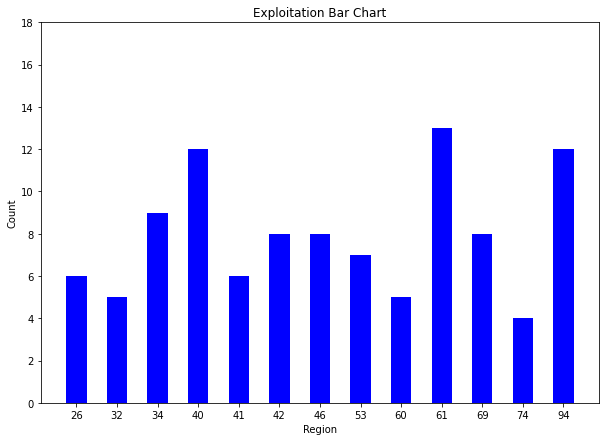

In [25]:
population.exploitation_bar_chart(3)

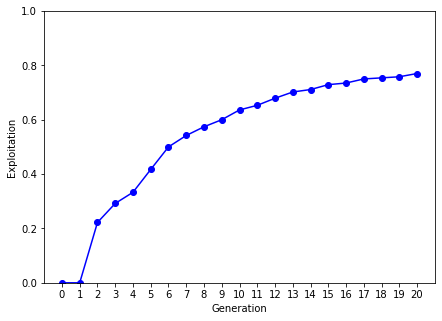

In [26]:
population.exploitation_vs_generation()

In [27]:
population.exploitation_value()

0.77

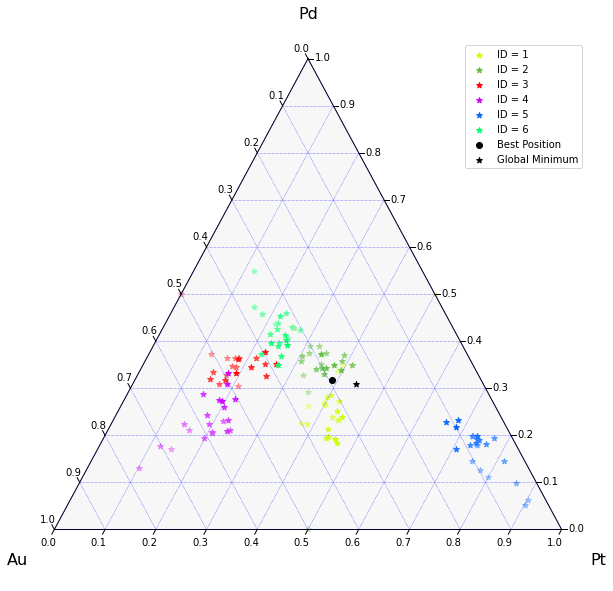

In [28]:
population.exploration_scatter()

In [ ]:
def find_correction(a):
    while a.max() > 1 or a.min() < 0:
        correction = []
        for i in range(3):
            if a[i] > 1:
                for x in range(i):
                    correction.append(-(1 - a[i])/(3-1))
                correction.append(1 - a[i])
                for x in range(3-1-i):
                    correction.append(-(1 - a[i])/(3-1))

            if a[i] < 0:
                for x in range(i):
                    correction.append(-(0 - a[i])/(3-1))
                correction.append(0 - a[i])
                for x in range(3-1-i):
                    correction.append(-(0 - a[i])/(3-1))

        correction = np.array(correction)
        correction = np.reshape(correction, (int(len(correction)/3), 3))
        for i in range(len(correction)):
             a = a + correction[i]
    return a

In [ ]:
b = np.array([-0.3, -0.3, 1.6])
find_correction(b)

In [ ]:
c = np.array([-3.3, 2.4, 0.9])
d = np.abs(c)
e = d - (sum(d)/3)
f = e/np.sqrt(sum(e**2))
g = f * np.sqrt(sum(d**2)) * 0.2

In [ ]:
e

In [ ]:
f

In [ ]:
g

In [ ]:
np.sqrt(sum((f * np.sqrt(sum(d**2)))**2))

In [ ]:
np.sqrt(sum(d**2))

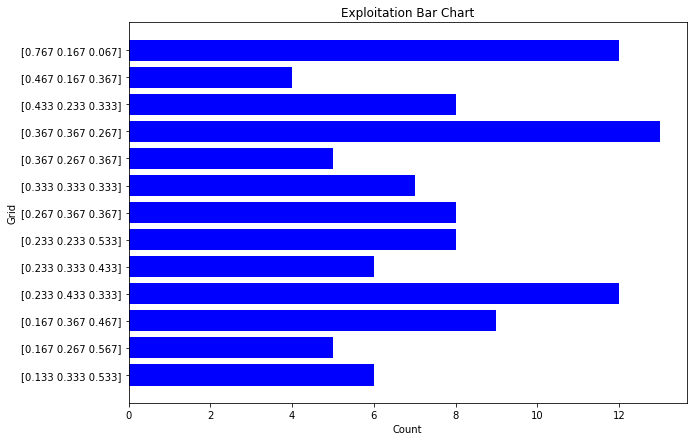

In [41]:
#Horizontal Bar Chart
a = population.exploitation_bar_chart_table
#Figure Size
fig, ax = plt.subplots(figsize =(10, 7))

#Horizontal Bar Plot
ax.barh(a['Grid'], a['Count'],
        color ='blue')

plt.xlabel("Count")
plt.ylabel("Grid")
plt.title("Exploitation Bar Chart")
plt.show()

In [39]:
#Making a grid
grid_len = 10
a = qe.simplex_grid(3, grid_len)/grid_len

#Translating Process
translate_vector = 1/(grid_len*3)
b = a + np.array([translate_vector, -2*translate_vector, translate_vector])
b = np.around(b, decimals = 3)

#Second type of grid
c = b + np.array([translate_vector, -2*translate_vector, translate_vector])
c = np.around(c, decimals = 3)

#Stacking
b = np.vstack((b,c))

#Deleting grid points outside the space
b = np.delete(b, np.where(b<0)[0], axis = 0)
b = np.delete(b, np.where(b>1)[0], axis = 0)
b = b[b[:, 0].argsort()]

test = np.array([0.42, 0.28, 0.3])




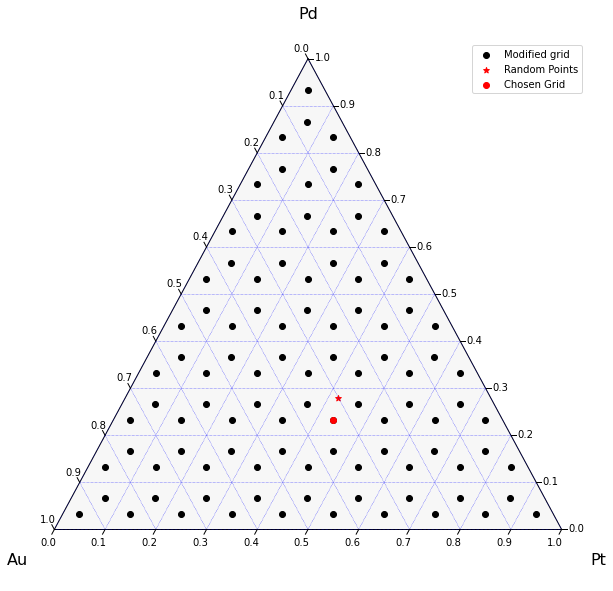

In [40]:
distance_b = []
for x in range(len(b)):
    distance_b.append(np.sqrt(sum((test-b[x])**2)))
distance_b = np.array(distance_b)
#Parameter for plotting
scale = 1
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(10, 10)

#Plotting the starting points
tax.scatter(tuple(b), marker='o', color='black', label='Modified grid')
tax.scatter([tuple(test)], marker='*', color='red', label='Random Points')
tax.scatter([tuple(b[distance_b.argmin()])], marker='o', color='red', label='Chosen Grid')
tax.legend()


tax.right_corner_label("Pt", fontsize=16)
tax.top_corner_label("Pd", fontsize=16)
tax.left_corner_label("Au", fontsize=16)
tax.boundary(linewidth=1.0)
tax.gridlines(multiple=1/grid_len, color="blue")
tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f")
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.show() 

In [ ]:
distance_c = []
for x in range(len(c)):
    distance_c.append(np.sqrt(sum((test-c[x])**2)))
distance_c = np.array(distance_c)
#Parameter for plotting
scale = 1
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(10, 10)

#Plotting the starting points
tax.scatter(tuple(c), marker='o', color='black', label='Modified grid')
tax.scatter([tuple(test)], marker='*', color='red', label='Random Points')
tax.scatter([tuple(c[distance_c.argmin()])], marker='o', color='red', label='Chosen Grid')
tax.legend()


tax.right_corner_label("Pt", fontsize=16)
tax.top_corner_label("Pd", fontsize=16)
tax.left_corner_label("Au", fontsize=16)
tax.boundary(linewidth=1.0)
tax.gridlines(multiple=0.1, color="blue")
tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f")
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.show() 

In [ ]:
magnitude_limit = 0.1
target = np.array([0.333, 0.333, 0.333])
population = pso(pd.read_csv('Result/Initial Population.txt', sep='\t'), magnitude_limit, target)

In [ ]:
population.datalog

In [ ]:
factor_1 = 1.2
factor_2 = 1.2
factor_3 = 0.5
mutation_prob = 0.7
mutation_rate = 0.5
magnitude_limit = 0.1

for i in range(5):
    population.move()
    display(population.working_generation)
    print(population.g_best()['Position'], population.g_best()['Activity'])
    print(np.sqrt(sum((population.g_best()['Position']-best_grid)**2)))

In [ ]:
factor_1 = 0.95
factor_2 = 1.2
factor_3 = 0.5
mutation_prob = 0.7
mutation_rate = 0.4
magnitude_limit = 0.25

for i in range(15):
    population.move()
    display(population.working_generation)
    print(population.g_best()['Position'], population.g_best()['Activity'])
    print(np.sqrt(sum((population.g_best()['Position']-best_grid)**2)))

In [ ]:
population.plot()

In [ ]:
population.g_best()